# Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from pathlib import Path
import torch
from torch.utils.data import TensorDataset ,DataLoader
from torch import nn,optim
import torch.nn.functional as F
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from torchvision import datasets,transforms

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/test.csv
/kaggle/input/train.csv
/kaggle/input/sample_submission.csv


In [2]:
train=pd.read_csv('/kaggle/input/train.csv')
test=pd.read_csv('/kaggle/input/test.csv')
train.shape,test.shape

((42000, 785), (28000, 784))

In [3]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
from torchvision import datasets,transforms

transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
trainset=datasets.MNIST('~/.pytorch/MNIST_data/',train=True,transform=transform,download=True)
validset=datasets.MNIST('~/.pytorch/MNIST_data/',train=False,transform=transform,download=True)

train_loader=torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True,num_workers=0)
valid_loader=torch.utils.data.DataLoader(validset,batch_size=64,shuffle=True,num_workers=0)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21253678.01it/s]                            


Extracting /tmp/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 225789.47it/s]           
0it [00:00, ?it/s]

Extracting /tmp/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 4851326.82it/s]                          
8192it [00:00, 129442.03it/s]


Extracting /tmp/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /tmp/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


# Network

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 5, 1)  #[in_channel,out_channel,filter_size,stride=1]
        self.conv2 = nn.Conv2d(3, 6, 5, 1)
        self.fc1 = nn.Linear(4*4*6, 140)
        self.fc2 = nn.Linear(140, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2)
        x = x.view(-1, 4*4*6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
      
# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=96, out_features=140, bias=True)
  (fc2): Linear(in_features=140, out_features=10, bias=True)
)


In [6]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print("Total_params",pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable_params",pytorch_total_params)

Total_params 15524
Trainable_params 15524


In [7]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# specify optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.003)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

In [8]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_mnist.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.249389 	Validation Loss: 0.071060
Validation loss decreased (inf --> 0.071060).  Saving model ...
Epoch: 2 	Training Loss: 0.076379 	Validation Loss: 0.065695
Validation loss decreased (0.071060 --> 0.065695).  Saving model ...
Epoch: 3 	Training Loss: 0.056156 	Validation Loss: 0.050118
Validation loss decreased (0.065695 --> 0.050118).  Saving model ...
Epoch: 4 	Training Loss: 0.049251 	Validation Loss: 0.065871
Epoch: 5 	Training Loss: 0.040663 	Validation Loss: 0.050615
Epoch: 6 	Training Loss: 0.037332 	Validation Loss: 0.047165
Validation loss decreased (0.050118 --> 0.047165).  Saving model ...
Epoch: 7 	Training Loss: 0.033508 	Validation Loss: 0.047516
Epoch: 8 	Training Loss: 0.030250 	Validation Loss: 0.046353
Validation loss decreased (0.047165 --> 0.046353).  Saving model ...
Epoch: 9 	Training Loss: 0.027554 	Validation Loss: 0.043718
Validation loss decreased (0.046353 --> 0.043718).  Saving model ...
Epoch: 10 	Training Loss: 0.025052 	Valida

In [9]:
# specify the image classes
classes = ['0', '1', '2', '3', '4',
           '5', '6', '7', '8', '9']

In [11]:
batch_size=16
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in valid_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.047798

Test Accuracy of     0: 99% (247/249)
Test Accuracy of     1: 98% (274/277)
Test Accuracy of     2: 100% (279/279)
Test Accuracy of     3: 96% (248/256)
Test Accuracy of     4: 98% (233/236)
Test Accuracy of     5: 98% (208/212)
Test Accuracy of     6: 98% (254/257)
Test Accuracy of     7: 96% (213/220)
Test Accuracy of     8: 98% (253/256)
Test Accuracy of     9: 97% (262/270)

Test Accuracy (Overall): 98% (2471/2512)


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
# helper function to de-normalize and display an image
def imshow(img):
    #img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)).squeeze())  # convert from Tensor image

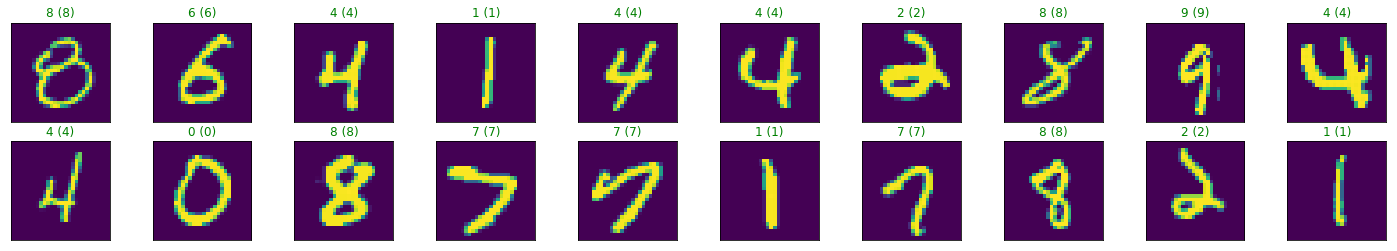

In [13]:
valid_loader=torch.utils.data.DataLoader(validset,batch_size=20,shuffle=True,num_workers=0)


# obtain one batch of test images
dataiter = iter(valid_loader)
images, labels = dataiter.next()
images.numpy()


# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [14]:
class DatasetSubmissionMNIST(torch.utils.data.Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = self.data.iloc[index].values.astype(np.uint8).reshape((28, 28, 1))

        
        if self.transform is not None:
            image = self.transform(image)
            
        return image

In [15]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

submissionset = DatasetSubmissionMNIST('../input/test.csv', transform=transform)
submissionloader = torch.utils.data.DataLoader(submissionset, batch_size=64, shuffle=False)

In [16]:
submission = [['ImageId', 'Label']]

with torch.no_grad():
    model.eval()
    image_id = 1

    for images in submissionloader:
        if train_on_gpu:
            images = images.cuda()
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        
        for prediction in top_class:
            submission.append([image_id, prediction.item()])
            image_id += 1
            
print(len(submission) - 1)

28000


In [17]:


import csv

with open('submission.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerows(submission)
    
print('Submission Complete!')



Submission Complete!
